In [1]:
#standard imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#import tensorflow and keras
import tensorflow as tf
from tensorflow import keras

import seaborn as sns
sns.set(style= "darkgrid", color_codes = True)
from tensorflow.keras.applications import VGG16

#import generic model class
from tensorflow.keras import Model, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.regularizers import l2
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.preprocessing.image import  load_img, ImageDataGenerator
from keras.optimizers import RMSprop,Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')

#import random
import random as rn
from random import randrange

#Usefull imports from kaggle
import glob
from PIL import Image
import os
import cv2

#function for fast generation of training and test set from data
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.layers import AvgPool2D

2023-08-21 18:05:51.955254: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-21 18:05:52.048669: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-21 18:05:52.049622: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-21 18:05:53.028953: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Define image size and other parameterst 

path = '/home/giacomo/git/Tittarelli_Giacomo_RetiNeurali/chest_xray/chest_xray/'
dimension = 50
img_width, img_height = dimension, dimension
batchsize = 32
num_of_class = 2

train = keras. utils.image_dataset_from_directory(
    directory= path + 'train',
    labels='inferred',
    label_mode='categorical',
    batch_size=batchsize,
    image_size=(img_width, img_height))

validation = keras. utils.image_dataset_from_directory(
    directory= path + 'val',
    labels='inferred',
    label_mode='categorical',
    batch_size=batchsize,
    image_size=(img_width, img_height))

test = keras. utils.image_dataset_from_directory(
    directory= path + 'test',
    labels='inferred',
    label_mode='categorical',
    batch_size=batchsize,
    image_size=(img_width, img_height))

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [3]:
# define paths
train_normal_dir = path + 'train/NORMAL/'
train_pneu_dir = path + 'train/PNEUMONIA/'

test_normal_dir = path + 'test/NORMAL/'
test_pneu_dir = path + 'test/PNEUMONIA/'

val_normal_dir = path + 'val/NORMAL/'
val_pneu_dir = path + 'val/PNEUMONIA/'


# find all files, our files has extension jpeg
train_normal_cases = glob.glob(train_normal_dir + '*jpeg')
train_pneu_cases = glob.glob(train_pneu_dir + '*jpeg')

test_normal_cases = glob.glob(test_normal_dir + '*jpeg')
test_pneu_cases = glob.glob(test_pneu_dir + '*jpeg')

val_normal_cases = glob.glob(val_normal_dir + '*jpeg')
val_pneu_cases = glob.glob(val_pneu_dir + '*jpeg')


# create lists for train, test & validation cases, create labels as well
train_list = []
test_list = []
val_list = []

for x in train_normal_cases:
    train_list.append([x, 0])
    
for x in train_pneu_cases:
    train_list.append([x, 1])
    
for x in test_normal_cases:
    test_list.append([x, 0])
    
for x in test_pneu_cases:
    test_list.append([x, 1])
    
for x in val_normal_cases:
    val_list.append([x, 0])
    
for x in val_pneu_cases:
    val_list.append([x, 1])


# shuffle/randomize data as they were loaded in order: normal cases, then pneumonia cases
rn.shuffle(train_list)
rn.shuffle(test_list)
rn.shuffle(val_list)


# create dataframes
train_df = pd.DataFrame(train_list, columns=['image', 'label'])
test_df = pd.DataFrame(test_list, columns=['image', 'label'])
val_df = pd.DataFrame(val_list, columns=['image', 'label'])

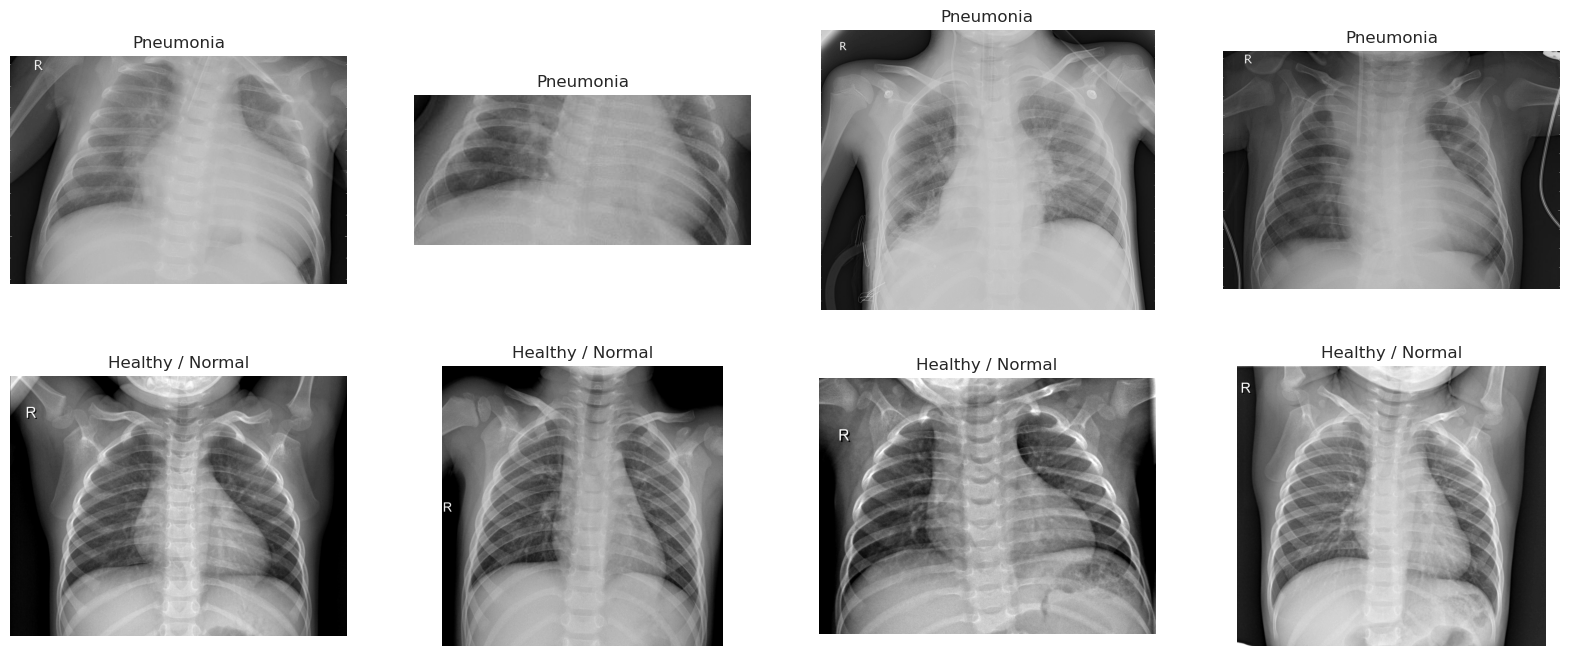

In [4]:
# Some plots before to go

plt.figure(figsize=(20,8))
for i,img_path in enumerate(train_df[train_df['label'] == 1][0:4]['image']):
    plt.subplot(2,4,i+1)
    plt.axis('off')
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.title('Pneumonia')
    
for i,img_path in enumerate(train_df[train_df['label'] == 0][0:4]['image']):
    plt.subplot(2,4,4+i+1)
    plt.axis('off')
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.title('Healthy / Normal')



In [5]:
# Proprocess the data
# RESIZE IMPORTANTE PER VELOCIZZARE ALGORITMO

resize = 34

def process_data(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (resize, resize))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (resize,resize,1))
    
    return img

def compose_dataset(df):
    data = []
    labels = []

    for img_path, label in df.values:
        data.append(process_data(img_path))
        labels.append(label)
        
    return np.array(data), np.array(labels)

In [6]:
X_train, y_train = compose_dataset(train_df)
X_test, y_test = compose_dataset(test_df)
X_val, y_val = compose_dataset(val_df)

print('Train data shape: {}, Labels shape: {}'.format(X_train.shape, y_train.shape))
print('Test data shape: {}, Labels shape: {}'.format(X_test.shape, y_test.shape))
print('Validation data shape: {}, Labels shape: {}'.format(X_val.shape, y_val.shape))

Train data shape: (5216, 34, 34, 1), Labels shape: (5216,)
Test data shape: (624, 34, 34, 1), Labels shape: (624,)
Validation data shape: (16, 34, 34, 1), Labels shape: (16,)


In [7]:
# define generator
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range = 0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)

# fit generator on our train features
datagen.fit(X_train)

y_train_cat = keras.utils.to_categorical(y_train, num_of_class)
y_val_cat = keras.utils.to_categorical(y_val, num_of_class)
y_test_cat = keras.utils.to_categorical(y_test, num_of_class)


In [8]:
# K-Fold

# Define the number of folds
num_folds = 6

all_data = np.concatenate((X_train, X_val))
all_labels = np.concatenate((y_train_cat, y_val_cat))

# Initialize the KFold object
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize lists to store results
all_histories = []

# Loop through each fold
for fold, (train_index, val_index) in enumerate(kf.split(all_data)):
    print(f"Training on fold {fold + 1}/{num_folds}")
    
    # Split data into train and validation sets for this fold
    X_train_fold, X_val_fold = all_data[train_index], all_data[val_index]
    y_train_fold, y_val_fold = all_labels[train_index], all_labels[val_index]
    

Training on fold 1/6
Training on fold 2/6
Training on fold 3/6
Training on fold 4/6
Training on fold 5/6
Training on fold 6/6


In [9]:
resize = 34

model = Sequential()

model.add(Conv2D(filters=8, kernel_size=(7,7), padding='same', activation='relu', input_shape=(resize, resize, 1)))
model.add(Conv2D(filters=8, kernel_size=(7,7), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=16, kernel_size=(5,5), padding='same', activation='relu'))
model.add(Conv2D(filters=16, kernel_size=(5,5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

optimizer = Adam(learning_rate=0.0001, weight_decay=1e-5)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

callback = EarlyStopping(monitor='loss', patience=6)


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 34, 34, 8)         400       
                                                                 
 conv2d_1 (Conv2D)           (None, 34, 34, 8)         3144      
                                                                 
 max_pooling2d (MaxPooling2  (None, 17, 17, 8)         0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 16)        3216      
                                                                 
 conv2d_3 (Conv2D)           (None, 17, 17, 16)        6416      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 16)          0         
 g2D)                                                   

In [11]:
# Define some hyperparameter
# Sei su codice di prova! Fai massimo 2 epoche!
epochs = 20
batch_size = 6

In [12]:
# Train the model

history = model.fit(
    datagen.flow(X_train, y_train_cat, batch_size=batch_size),
    validation_data=(X_val_fold, y_val_fold),
    epochs=epochs,
    verbose=1,
    callbacks=[callback],
)

Epoch 1/20
870/870 [==============================] - 17s 18ms/step - loss: 0.4700 - accuracy: 0.7910 - val_loss: 0.2888 - val_accuracy: 0.8704
Epoch 2/20
870/870 [==============================] - 16s 18ms/step - loss: 0.2948 - accuracy: 0.8714 - val_loss: 0.2036 - val_accuracy: 0.9186
Epoch 3/20
870/870 [==============================] - 16s 18ms/step - loss: 0.2290 - accuracy: 0.9030 - val_loss: 0.2913 - val_accuracy: 0.8739
Epoch 4/20
870/870 [==============================] - 16s 18ms/step - loss: 0.2172 - accuracy: 0.9099 - val_loss: 0.1642 - val_accuracy: 0.9358
Epoch 5/20
870/870 [==============================] - 16s 18ms/step - loss: 0.1971 - accuracy: 0.9199 - val_loss: 0.1588 - val_accuracy: 0.9415
Epoch 6/20
870/870 [==============================] - 16s 18ms/step - loss: 0.1919 - accuracy: 0.9220 - val_loss: 0.1438 - val_accuracy: 0.9495
Epoch 7/20
870/870 [==============================] - 16s 18ms/step - loss: 0.1728 - accuracy: 0.9285 - val_loss: 0.1630 - val_accuracy:

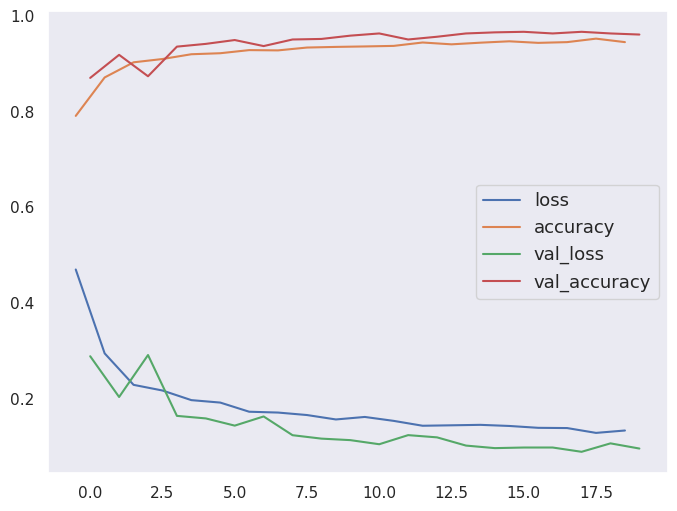

In [13]:
#plot learning curves

fig, ax = plt.subplots(figsize=(8,6))

for metric in history.history:
    
    #subtract half epoch from training data
    if len(metric.split('_')) < 2:
        ax.plot(np.array(history.epoch)-.5, history.history[metric], label=metric)
    else:
        ax.plot(history.epoch, history.history[metric], label=metric)
    
ax.grid()    

ax.legend(fontsize=13);

In [14]:
# Randomize 

seed_value = 42
rn.seed(seed_value)


In [15]:
#identify wrong predictions in the training set

y_train_pred = model.predict(X_train).argmax(axis=1)


163/163 [==============================] - 2s 9ms/step


In [16]:
idx_wrong = np.where(y_train_pred != y_train)[0] #positions of the wrongly classified data

num_wrong = len(idx_wrong)
print(num_wrong)

187


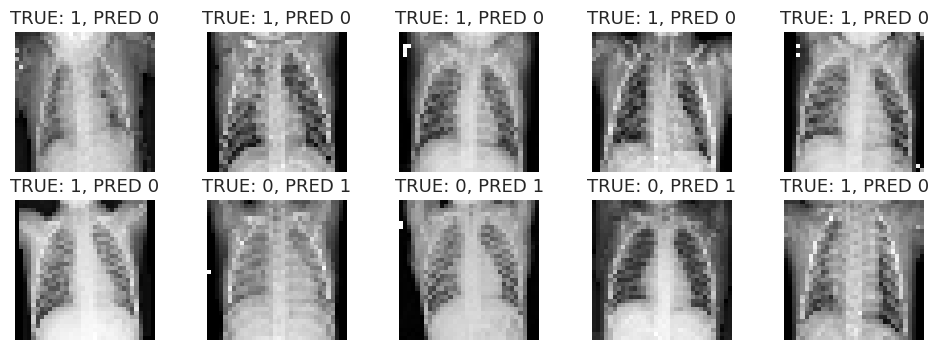

In [17]:
# show the first 10 wrong predictions the training set

fig, axs = plt.subplots(2,5,figsize=(12,4))

for i in range(10):
    
    ax = axs.ravel()[i]
    
    idx = idx_wrong[randrange(0, num_wrong)]
    
    ax.imshow(X_train[idx], cmap='gray')
    ax.set_title('TRUE: {}, PRED {}'.format(y_train[idx], y_train_pred[idx]), fontsize=13)
    ax.axis('off')

In [18]:
#identify correct predictions in the training set

y_train_pred = model.predict(X_train).argmax(axis=1)

idx_correct = np.where(y_train_pred == y_train)[0] #positions of the wrongly classified data

num_correct = len(idx_correct)

print(num_correct)

163/163 [==============================] - 1s 9ms/step
5029


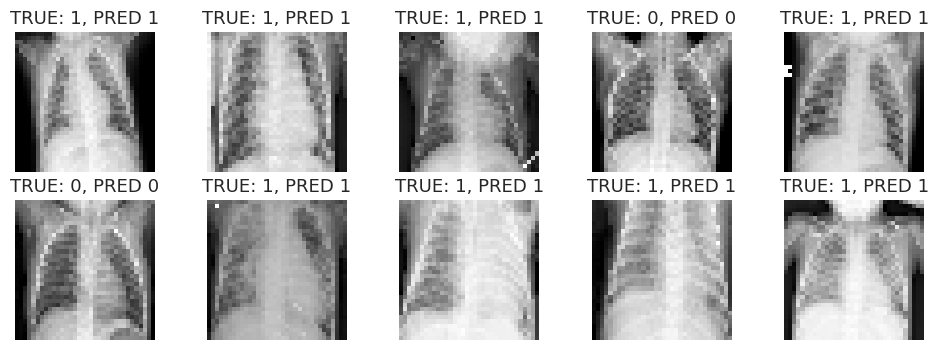

In [19]:
# show 10 correct predictions the training set

fig, axs = plt.subplots(2,5,figsize=(12,4))

for i in range(10):
    
    ax = axs.ravel()[i]
    
    idx = idx_correct[randrange(0, num_correct)]
    
    ax.imshow(X_train[idx], cmap='gray')
    ax.set_title('TRUE: {}, PRED {}'.format(y_train[idx], y_train_pred[idx]), fontsize=13)
    ax.axis('off')